r_base

# Enrichment analysis for Non-Model Species

### 0.Set up the environment

In [1]:
library(data.table)
library(stringr)
library(dplyr)
library(Seurat)
library(ggplot2)
library(clusterProfiler)
library(tidyverse)
library(ontologyIndex)
library(enrichplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




clusterProfiler v4.14.6 Learn more at https://yulab-smu.top/contribution-knowledge-mining/

Please cite:

G Yu. Thirteen years of clusterProfiler. The Innovation. 2024,
5(6):100722


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:stats’:

    filter


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ readr     2.1.5
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ─────────────────────────

### 1.Preparing Term to Gene table

http://eggnog-mapper.embl.de/

In [2]:
# prepare the term to gene table
eggNOG <- read_tsv("specie.emapper.annotations.tsv") %>%
    dplyr::select(GOs, `query`) %>%
    dplyr::filter(GOs != "-") %>%
    separate_rows(GOs, sep = ",") %>%
    # mutate(gene = gsub("\\..*", "", `query`)) %>%
    select(GOs, gene = query) %>%
    distinct() %>%
    drop_na()
colnames(eggNOG) <- c("term", "gene")

Rows: 15357 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (19): query, seed_ortholog, eggNOG_OGs, max_annot_lvl, COG_category, Des...
dbl  (2): evalue, score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(eggNOG)

term,gene
<chr>,<chr>
GO:0003674,XLOC-000965#EXOG-DANRE#Q502K1
GO:0003824,XLOC-000965#EXOG-DANRE#Q502K1
GO:0004518,XLOC-000965#EXOG-DANRE#Q502K1
GO:0004519,XLOC-000965#EXOG-DANRE#Q502K1
GO:0004527,XLOC-000965#EXOG-DANRE#Q502K1
GO:0005575,XLOC-000965#EXOG-DANRE#Q502K1


### 2.Preparing Term to name table

https://current.geneontology.org/ontology/go.obo

In [4]:
# prepare the term to name table
ontology <- get_ontology(file = "go.obo",
                         propagate_relationships = "is_a",
                         extract_tags = "everything",
                         merge_equivalent_terms = TRUE)
eggNOG_term <- eggNOG %>%
    mutate(name = ontology$name[term]) %>%
    select(c(term, name)) %>%
    distinct() %>%
    drop_na() %>%
    filter(!grepl("obsolete", name))

eggNOG <- eggNOG %>%
    filter(term %in% eggNOG_term$term)

In [5]:
write_tsv(x = eggNOG, file = "term2gene_GO.tsv")
write_tsv(x = eggNOG_term, file = "term2name_GO.tsv")

### 3.Background gene list

In [6]:
# 单细胞中的基因
seurat_genes <- read.csv("specie.singlecell.genes.csv", stringsAsFactors = FALSE)$gene
length(seurat_genes)

# eggNOG中的基因
eggNOG_genes <- eggNOG$gene |> unique()
length(eggNOG_genes)

# 背景基因：研究中被检测到的基因∩数据库能识别的基因
background_genes <- intersect(seurat_genes, eggNOG_genes)
length(background_genes)

[1] 17676

[1] 9993

[1] 6213

In [7]:
class(background_genes)
is.vector(background_genes)

[1] "character"

[1] TRUE

### 4.The gene set of interest

In [8]:
markers_table <- read_csv("specie.cluster.genes.csv")

interesting_genes <- markers_table %>%
  filter(abs(avg_log2FC) >= 1.5,
         p_val_adj <= 0.05) %>%
  dplyr::select(gene) %>%
  unlist() %>%
  as.vector()

length(interesting_genes)

Rows: 2546 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (6): p_val, avg_log2FC, pct.1, pct.2, p_val_adj, cluster

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 422

### 5.ORA via clusterProfiler

In [9]:
# perform ORA
term2gene <- read_tsv("term2gene_GO.tsv")
term2name <- read_tsv("term2name_GO.tsv")

enrichment <- enricher(interesting_genes,
                       TERM2GENE = term2gene,
                       TERM2NAME = term2name,
                       pvalueCutoff = 0.05,
                       universe = background_genes,
                       qvalueCutoff = 0.05)
#save the enrichment result
write.csv(file = paste0("enrichment_GO_results.csv"),                 # EDIT THIS
          x = enrichment@result)

if (any(enrichment@result$p.adjust <= 0.05)){
    p <- dotplot(enrichment,
                 x= "geneRatio", # Options: GeneRatio, BgRatio, pvalue, p.adjust, qvalue
                 color="p.adjust",
                 orderBy = "x", # Options: GeneRatio, BgRatio, pvalue, p.adjust, qvalue
                 showCategory=50,
                 font.size=8,
                 label_format = 200 # 标签属于长度
                 ) +
        ggtitle("dotplot for GO ORA")
    
    ggsave(filename = paste0("enrichment_GO_dotplot.pdf"),                # EDIT THIS
           plot =  p,  dpi = 300, width = 21, height = 42, units = "cm")
}

Rows: 1211186 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): term, gene

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 17344 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): term, name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 6.KEGG

wget https://rest.kegg.jp/link/ko/pathway -O ko_pathway_link.txt

wget https://rest.kegg.jp/list/pathway/ko -O ko_pathway_list.txt

In [10]:
# === 1. 构建 term2gene / term2name ===
link <- read_tsv("ko_pathway_link.txt", col_names = FALSE)
list <- read_tsv("ko_pathway_list.txt", col_names = FALSE)

term2gene_kegg <- link %>%
  filter(grepl("^path:ko", X1)) %>%  # 只保留 path:ko 开头的行
  mutate(
    term = gsub("path:ko", "", X1),   # Pathway ID
    gene = gsub("ko:", "", X2)        # KO ID
  ) %>%
  select(term, gene) %>%
  distinct()

term2name_kegg <- list %>%
  mutate(
    term = gsub("ko", "", X1),        # 保证 term 与 term2gene 一致
    name = X2
  ) %>%
  select(term, name)

Rows: 95556 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 497 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): X1, X2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [11]:
head(term2gene_kegg)

term,gene
<chr>,<chr>
00010,K00001
00010,K00002
00010,K00016
00010,K00114
00010,K00121
00010,K00128


In [12]:
head(term2name_kegg)

term,name
<chr>,<chr>
01100,Metabolic pathways
01110,Biosynthesis of secondary metabolites
01120,Microbial metabolism in diverse environments
01200,Carbon metabolism
01210,2-Oxocarboxylic acid metabolism
01212,Fatty acid metabolism


In [13]:
# === 2. 从 eggNOG 中提取 KEGG 对应 ===
eggNOG_kegg <- read_tsv("specie.emapper.annotations.tsv") %>%
    dplyr::select(KEGG_ko, `query`) %>%
    dplyr::filter(KEGG_ko != "-") %>%
    separate_rows(KEGG_ko, sep = ",") %>%
    dplyr::mutate(gene = query) %>%
    dplyr::mutate(term = gsub("ko:", "", KEGG_ko)) %>%
    dplyr::select(term, gene) %>%
    distinct() %>%
    drop_na()
    
# === 3. 定义基因集合 ===
interesting_set_kegg <- eggNOG_kegg %>%
    dplyr::filter(gene %in% interesting_genes) %>%
    unlist() %>%
    as.vector()
# create a list of kegg ortholog that includes all kegg orthologs which form my background
background_kegg <- eggNOG_kegg %>%
    dplyr::filter(gene %in% background_genes) %>%
    unlist() %>%
    as.vector()

# enrichment_kegg <- enrichKEGG(interesting_set_kegg,
#            organism = "ko",
#            keyType = "kegg",
#            pvalueCutoff = 0.05,
#            pAdjustMethod = "BH",
#            universe = background_kegg,
#            minGSSize = 10,
#            maxGSSize = 500,
#            qvalueCutoff = 0.05,
#            use_internal_data = FALSE)

# === 4. 运行离线 KEGG 富集 ===
enrichment_kegg <- enricher(
  gene = interesting_set_kegg,        # 感兴趣基因（KO ID 或基因名）
  TERM2GENE = term2gene_kegg,      # pathway–gene 对照表
  TERM2NAME = term2name_kegg,      # pathway 名称表
  universe = background_kegg,     # 背景基因
  pAdjustMethod = "BH",
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05
)
#save the enrichment result
write.csv(file = paste0("enrichment_KEGG_results.csv"),                 # EDIT THIS
          x = enrichment_kegg@result)

if (any(enrichment_kegg@result$p.adjust <= 0.05)){
    p <- dotplot(enrichment_kegg,
                 x= "geneRatio", # Options: GeneRatio, BgRatio, pvalue, p.adjust, qvalue
                 color="p.adjust",
                 orderBy = "x", # Options: GeneRatio, BgRatio, pvalue, p.adjust, qvalue
                 showCategory=100,
                 font.size=8) +
        ggtitle("dotplot for KEGG ORA")
    
    ggsave(filename = paste0("enrichment_KEGG_dotplot.pdf"),                # EDIT THIS
           plot =  p,  dpi = 300, width = 21, height = 42, units = "cm")
}


Rows: 15357 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (19): query, seed_ortholog, eggNOG_OGs, max_annot_lvl, COG_category, Des...
dbl  (2): evalue, score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 7.GSEA

In [14]:
# GSEA
# This time I am not filtering the changes
# gsea_list <- read_tsv("comparison_6.tsv") %>%
#     dplyr::arrange(desc(logFC))
gsea_list <- markers_table %>%
    dplyr::arrange(desc(avg_log2FC))
gsea_input <- gsea_list %>%
    # dplyr::select(logFC) %>%
    dplyr::select(avg_log2FC) %>%
    unlist() %>%
    as.vector()
names(gsea_input) <- gsea_list$gene
head(gsea_input)

gene-evm.model.ptg000010l.338-1   gene-evm.model.ptg000001l.379 
                       7.296847                        6.809997 
 XLOC-022353#HMCN1-MOUSE#D3YXG0  XLOC-013482#HMCN1-MOUSE#D3YXG0 
                       6.701415                        6.471938 
  XLOC-013483#CADN-ACRMI#B3EWZ3  XLOC-002244#TMPS2-MOUSE#Q9JIQ8 
                       6.127296                        6.119738

In [15]:

# do the analysis below
enrichment_gsea <- GSEA(geneList = gsea_input,
                        TERM2GENE = term2gene,
                        TERM2NAME = term2name,
                        minGSSize = 10,
                        maxGSSize = 500,
                        eps = 1e-10,
                        pvalueCutoff = 0.05,
                        pAdjustMethod = "BH")
#save the enrichment result
write.csv(file = paste0("enrichment_GSEA_results.csv"),                 # EDIT THIS
          x = enrichment_gsea@result)

if (any(enrichment_gsea@result$p.adjust <= 0.05)){
    # p <- ridgeplot(enrichment_gsea,
    #                core_enrichment= FALSE,
    #                fill="p.adjust",
    #                orderBy = "NES",
    #                showCategory=100) +
    #     ggtitle("Ridge plot for GSEA")
    p <- dotplot(enrichment_gsea,
             showCategory = 30,
             split = NULL,
             color = "p.adjust",
             label_format = 200) +
     ggtitle(paste0("GSEA dotplot (cluster ", cluster_id, ")")) +
     theme(plot.title = element_text(size = 14, face = "bold"))
    
    ggsave(filename = paste0("enrichment_GSEA_dotplot.pdf"),                # EDIT THIS
           plot =  p,  dpi = 300, width = 21, height = 42, units = "cm")
}

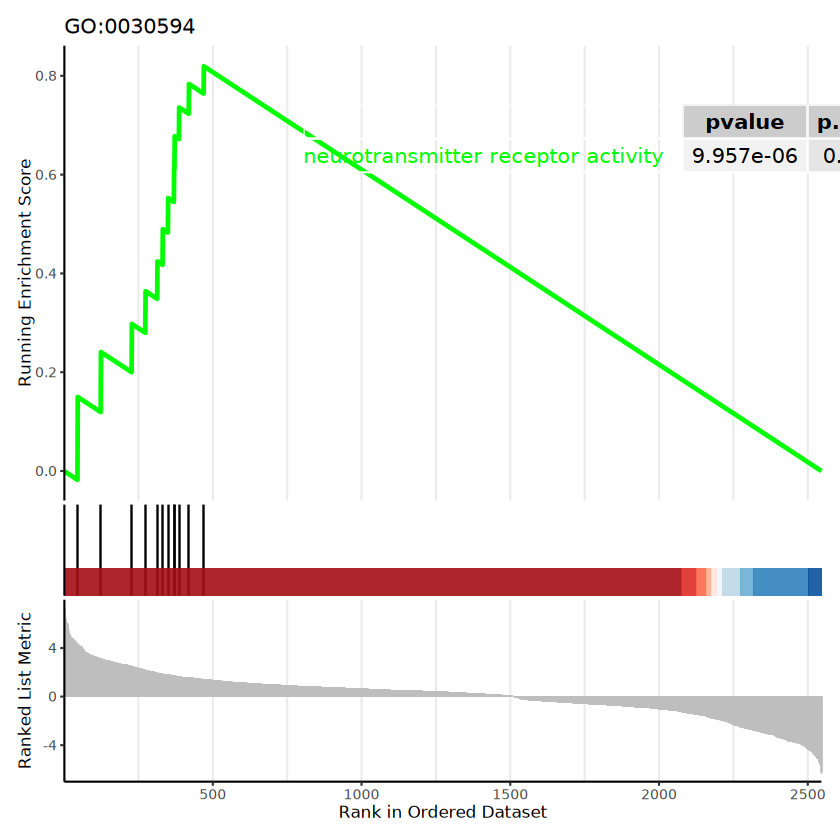

In [ ]:
gseaplot2(
    enrichment_gsea,
    geneSetID = "GO:0030594",
    title = "GO:0030594",
    base_size = 10,
    rel_heights = c(1, 0.2, 0.4),#小图相对高度
    subplots = 1:3,#展示小图
    pvalue_table = TRUE,#p值表格
    ES_geom = "line"#line or dot
  )